# Product Demand Forecast

In [244]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL, seasonal_decompose

from tbats import TBATS, BATS

from itertools import product 

from time import time
from datetime import timedelta
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar

from tqdm.notebook import tqdm

In [2]:
def print_elapsed_time(start):
    elapsed = timedelta(seconds=time() - start)
    # remove millis
    elapsed = str(elapsed).split('.')[0]
    print('Elapsed time: {}'.format(elapsed))

In [3]:
def calc_datetime_delta(d1, d2, date_format='%Y-%m-%d'):
    d1 = datetime.strptime(d1, date_format)
    d2 = datetime.strptime(d2, date_format)
    delta = d2 - d1
    return delta.days

## Explore data

### Read input data

In [4]:
orig_train_df = pd.read_csv('dataset/demand-forecasting-kernels-only/train.csv')
print('Original: ' + str(orig_train_df.shape))
orig_train_df

Original: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


### Data preprocessing

Use more compact and consistent column names

In [5]:
train_df = orig_train_df.copy()
train_df.columns = ['date', 'store', 'item', 'sales']

Then, Let's check for NAs

In [6]:
train_df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

As we can see, only date column has NAs. Since we literally have no way to figure out the missing date, we need to drop all of them.

In [7]:
# remove NA
train_df.dropna(inplace=True)
print('After: ' + str(train_df.shape))

After: (913000, 4)


In [8]:
train_df.date = pd.to_datetime(train_df.date)

convert the data to daily

In [9]:
def group_demand_by(df, columns):
    df = df.groupby(columns).sum()
    df = df.reset_index().sort_values(columns)
    return df

In [10]:
train_df = group_demand_by(train_df, ['date', 'item', 'store'])
train_df

,date,item,store,sales
0,2013-01-01,1,1,13
1,2013-01-01,1,2,12
2,2013-01-01,1,3,19
3,2013-01-01,1,4,10
4,2013-01-01,1,5,11
...,...,...,...,...
912995,2017-12-31,50,6,45
912996,2017-12-31,50,7,46
912997,2017-12-31,50,8,76
912998,2017-12-31,50,9,65


A little summary for our data

In [11]:
def get_date_range(df, debugging=False):
    dates = df.date if 'date' in df.columns else df.index
    date_range = (dates.min(), dates.max())
    if debugging:
        print('({} - {})'.format(*date_range))
    return date_range

In [12]:
print('Date range: ')
date_range = get_date_range(train_df, debugging=True)
train_df.drop('date', axis=1).describe(include='all').iloc[:4,:]

Date range: 
(2013-01-01 00:00:00 - 2017-12-31 00:00:00)


,item,store,sales
count,913000.000000,913000.000000,913000.000000
mean,25.500000,5.500000,52.250287
std,14.430878,2.872283,28.801144
min,1.000000,1.000000,0.000000


### Generic plots

In [219]:
sns.set(rc={'figure.figsize':(15, 8)})

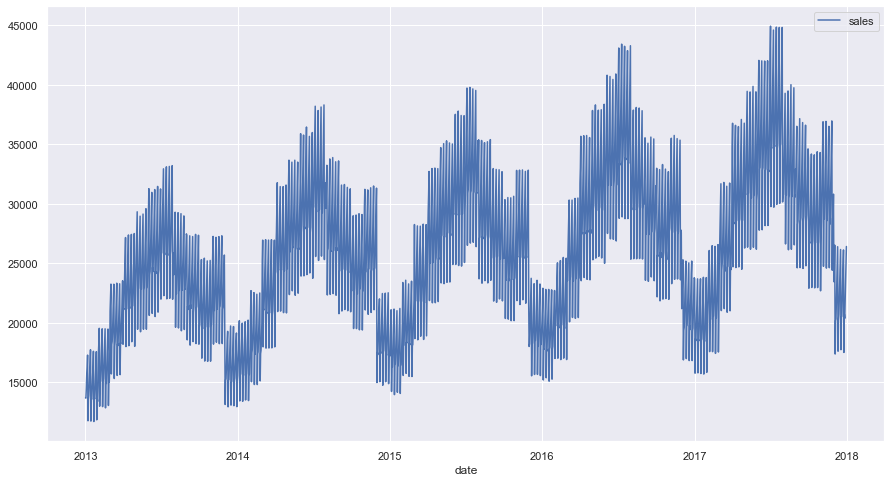

In [242]:
df = group_demand_by(train_df, ['date'])
df = df.drop(columns=['item', 'store']).set_index('date')
g = sns.lineplot(data=df)
g.get_figure().savefig('plots/generic.jpg')
del g

In [258]:
def plot_stl(df):
    sns.set(rc={'figure.figsize':(15, 4)})
    
    stl = STL(df)
    result = stl.fit()

    seasonal, trend, resid = result.seasonal, result.trend, result.resid

    fig = plt.figure(figsize=(15,8))

#     plt.subplot(4,1,1)
#     plt.plot(df)
#     plt.title('Original Series', fontsize=16)

    plt.subplot(4,1,2)
    plt.plot(trend)
    plt.title('Trend', fontsize=16)

    plt.subplot(4,1,3)
    plt.plot(seasonal)
    plt.title('Seasonal', fontsize=16)

#     plt.subplot(4,1,4)
#     plt.plot(resid)
#     plt.title('Residual', fontsize=16)

    plt.tight_layout()
    fig.savefig('plots/stl.jpg')

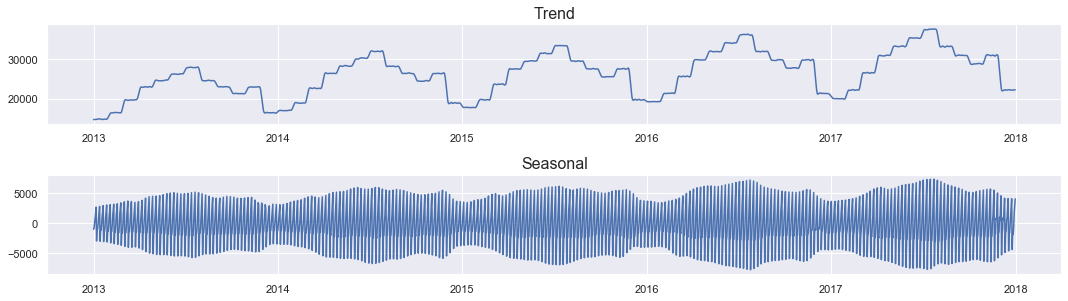

In [259]:
plot_stl(df)

In [15]:
# # sns.lineplot(data=demand_df, x='Date', y='Order_Demand', hue='Product_Category')

# cumsum_demand_df = demand_df.sort_values('Date')
# cumsum_demand_df['cumsum'] = cumsum_demand_df.groupby('Product_Category').cumsum()

# sns.lineplot(data=cumsum_demand_df, x='Date', y='cumsum', hue='Product_Category')

# del cumsum_demand_df

In [16]:
# demand_by_cat_df = demand_df.groupby('Product_Category').sum().reset_index()
# sns.set_style("whitegrid")
# g = sns.barplot(data=demand_by_cat_df, y='Order_Demand', x='Product_Category')
# g.set_yscale("log")
# del demand_by_cat_df, g

In [17]:
# g = sns.boxplot(data=demand_df, y='Order_Demand', x='Product_Category', showfliers=True)
# g.set_yscale("log")
# del g

In [18]:
# g = sns.boxplot(data=demand_df, y='Order_Demand', x='Warehouse', showfliers=True)
# g.set_yscale("log")
# del g

### Split dataset

In [19]:
test_df = pd.read_csv('dataset/demand-forecasting-kernels-only/test.csv', index_col='id')
# test_df = group_demand_by(test_df, ['date', 'item'])
test_df.date = pd.to_datetime(test_df.date)
test_df

,date,store,item
id,,,
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1
...,...,...,...
44995,2018-03-27,10,50
44996,2018-03-28,10,50
44997,2018-03-29,10,50


## Exploratory time-series analysis

### Stationarity check

In [20]:
# simple function to filter dataframe with given parameters
def filter_demand(df, item=None, store=None, category=None, sales=-1):
    df = df.copy()
    if item is not None:
        df = df[df.item == item]
    if store is not None:
        df = df[df.store == store]
    if category is not None:
        df = df[df.category == category]
    if sales > -1:
        df = df[df.sales > sales]
    return df

In [21]:
def is_stationary(df, print_stats=False):
    result = adfuller(df)
    if print_stats:
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
    return result[1] < 0.001

Check stationarity of 100 items with highest frequency

In [22]:
import warnings
def apply_differencing(df, periods=1, ffill=False, stationary_check=True):
    if isinstance(df, pd.DataFrame) and 'sales' in df.columns:
        df.sales = df.sales.diff(periods=periods)
    else:
        df = df.diff(periods=periods)
    df = df.ffill() if ffill else df.dropna()
        
    if stationary_check and not is_stationary(df.sales if isinstance(df, pd.DataFrame) else df):
        warnings.warn('DataFrame is still not stationary.')
    return df

Okay, now we have the function, we only need to call it when we build the model.

## Finding correlation  

First, since we're dealing with one product at a time, we need a simple function to filter dataset based on product code (ID). Since a lot of days will have no demand for that particulat product, we need to fill those missing dates with 0.

In [23]:
# a simple function to get appropriate training data
def get_train_data(df, date_range=None, differencing=0):
    # we don't need these columns now
    df = df.drop(columns=['store', 'item'])
    
    df = df.set_index('date')
    
    # fill date gap with 0
    if date_range is not None:
        idx = pd.date_range(*date_range)
        df = df.reindex(idx, fill_value=0)
        
    # apply diffencing of 0
    if differencing > 0:
        df = apply_differencing(df, periods=differencing)
    
    return df

Next, we need a specific product to find out the correlation

**Clarification**: Each product's demand might be completely different from each other, so the correlation of one product might not hold true to others, eventually produces inaccurate results. In the dataset, however, all the products are in high demand, e.g. staples, so there will be high chance that they have similar correlation.

In [24]:
# getting the item with highest demand
highest_freq_item = train_df.item.value_counts().index[0]
highest_freq_item_df = filter_demand(train_df, item=highest_freq_item, store=1)
train_date_range = get_date_range(train_df, debugging=True)
item_df = get_train_data(highest_freq_item_df, train_date_range)
item_diff_df = get_train_data(highest_freq_item_df, train_date_range, differencing=True)
del highest_freq_item_df

(2013-01-01 00:00:00 - 2017-12-31 00:00:00)


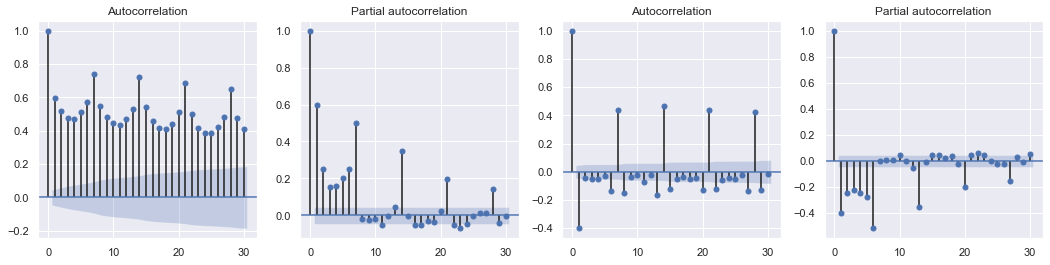

In [227]:
fig, ax = plt.subplots(1, 4, figsize=(18,4))
lags = 30
g1 = sm.graphics.tsa.plot_acf(item_df, lags=lags, ax=ax[0], title='Autocorrelation')
g2 = sm.graphics.tsa.plot_pacf(item_df, lags=lags, ax=ax[1], title='Partial autocorrelation')
sm.graphics.tsa.plot_acf(item_diff_df, lags=lags, ax=ax[2], title='Autocorrelation')
sm.graphics.tsa.plot_pacf(item_diff_df, lags=lags, ax=ax[3], title='Partial autocorrelation')
fig.savefig('plots/ACF.jpg')

It is quite obvious that the item also has weekly seasonality.

In this project, I will use **_TBATS_**, a method specifically designed to handle datasets with multiple seasonalities. The traditional **_SARIMA_** model will also be conducted to compare the results.

## SARIMA

Autoregressive integrated moving average

In [26]:
sarima_pred = pd.read_csv('sarima_prediction.csv')
sarima_pred.pred = sarima_pred.pred.apply(lambda row: np.fromstring(row, dtype=float, sep=' '))
sarima_pred

,store,item,pred
0,1,1,"[12.95995873008626, 15.008058582378881, 15.858..."
1,1,2,"[37.279777142743, 43.88389223200109, 45.898817..."
2,1,3,"[19.848068079221946, 23.05812010401695, 24.022..."
3,1,4,"[12.031572145174511, 14.9667525983203, 15.0000..."
4,1,5,"[10.392817088409286, 12.439485796718262, 13.02..."
...,...,...,...
495,10,46,"[42.66407080556636, 51.724830575514225, 51.873..."
496,10,47,"[13.518017221893516, 17.087480581743513, 16.79..."
497,10,48,"[35.452437173804114, 42.042652592598635, 43.84..."
498,10,49,"[20.95433607179981, 24.702551997537995, 25.979..."


In [27]:
# raw prediction doesn't have dates, so we need to figure it out
pred_count = len(sarima_pred.pred[0])
pred_start_date = test_df.date[0]
pred_end_date = pred_start_date + timedelta(days=pred_count - 1)
pred_date_range = pd.date_range(pred_start_date, pred_end_date)

def get_prediction_df(df, item, store):
    df = filter_demand(df, store=store, item=item)
    df = pd.DataFrame(df.pred.values[0], columns=['pred'])
    df.index = pred_date_range
    return df

In [231]:
def plot_prediction(df, item, store, method):
    # train data
    train_plot_df = filter_demand(train_df, item=item, store=store) \
                        .drop(columns=['item', 'store']) \
                        .set_index('date')
    train_plot_df = train_plot_df[train_plot_df.index > '01-01-2015']
    # prediction
    pred_plot_df = get_prediction_df(df, item, store)
    # join and plot
    df = train_plot_df.join(pred_plot_df, how='outer')
    g = sns.lineplot(data=df)
    plt.title('Prediction for item {} of store {}'.format(item, store))
    g.get_figure().savefig('plots/{}_{}_{}.jpg'.format(method, item, store))

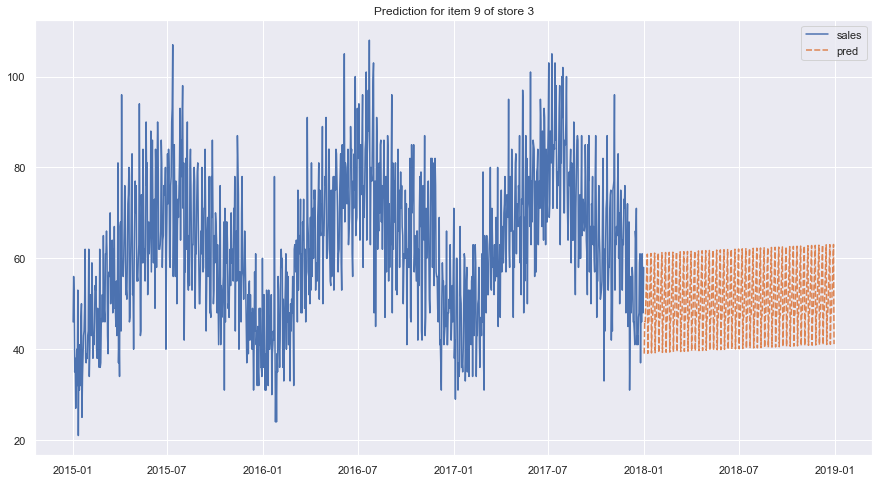

In [232]:
item = 9
store = 3
plot_prediction(sarima_pred, item=item, store=store, method='sarima')

## SARIMA with FFT

In [237]:
sarima_fourier_pred = pd.read_csv('sarima_fourier_prediction.csv')
sarima_fourier_pred.pred = sarima_fourier_pred.pred.apply(lambda row: np.fromstring(row, dtype=float, sep=' '))
sarima_fourier_pred

,store,item,pred
0,1,1,"[13.553793106647642, 15.014512959778116, 16.03..."
1,1,2,"[36.50137175272698, 43.0890430220263, 44.97598..."
2,1,3,"[23.398656371064362, 25.56412723952539, 27.707..."
3,1,4,"[12.909964181149263, 15.94886875242646, 15.845..."
4,1,5,"[11.177424389231845, 12.932591882931696, 13.49..."
...,...,...,...
495,10,46,"[44.26825099151676, 54.62354204994761, 53.1415..."
496,10,47,"[14.499124446740467, 17.909435715340983, 17.55..."
497,10,48,"[39.4307170449847, 44.654777550008546, 48.3648..."
498,10,49,"[21.796606096108107, 24.655239684156022, 26.55..."


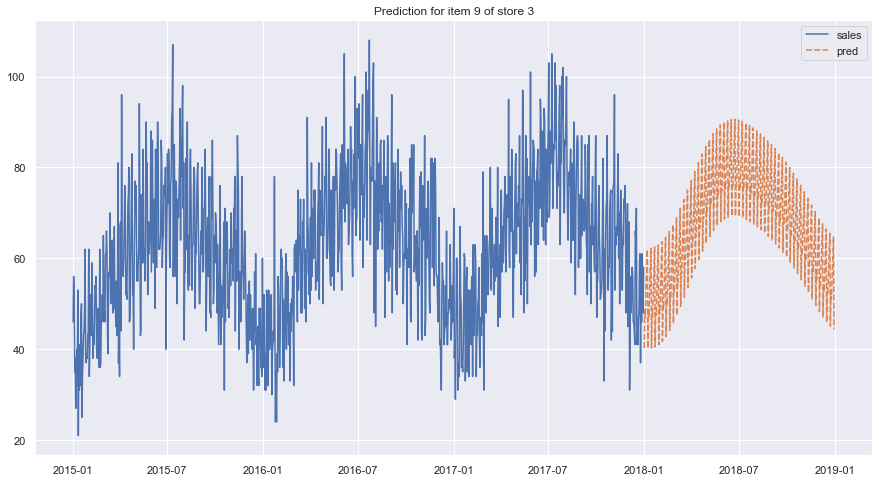

In [238]:
plot_prediction(sarima_fourier_pred, item=item, store=store, method='sarima_fourier')

## TBATS

Trigonometric seasonality, Box-Cox transformation, ARMA errors, Trend and Seasonal components.

In [32]:
tbats_pred = pd.read_csv('tbats_prediction.csv')
tbats_pred.pred = tbats_pred.pred.apply(lambda row: np.fromstring(row, dtype=float, sep=' '))
tbats_pred

,store,item,pred
0,1,1,"[12.242869306880271, 14.49259298637672, 14.902..."
1,1,2,"[37.5279519171771, 42.69891035474147, 43.56292..."
2,1,3,"[20.92385417815212, 23.505206702477363, 24.753..."
3,1,4,"[11.473460397431216, 13.785472532956769, 14.49..."
4,1,5,"[10.098998134537926, 11.996642160952337, 12.03..."
...,...,...,...
495,10,46,"[43.165719402603585, 50.14233679016865, 50.344..."
496,10,47,"[15.823532781458326, 17.866756044763484, 17.70..."
497,10,48,"[36.08575390408136, 41.113975195556684, 41.979..."
498,10,49,"[21.89277739255599, 25.232146051746767, 25.128..."


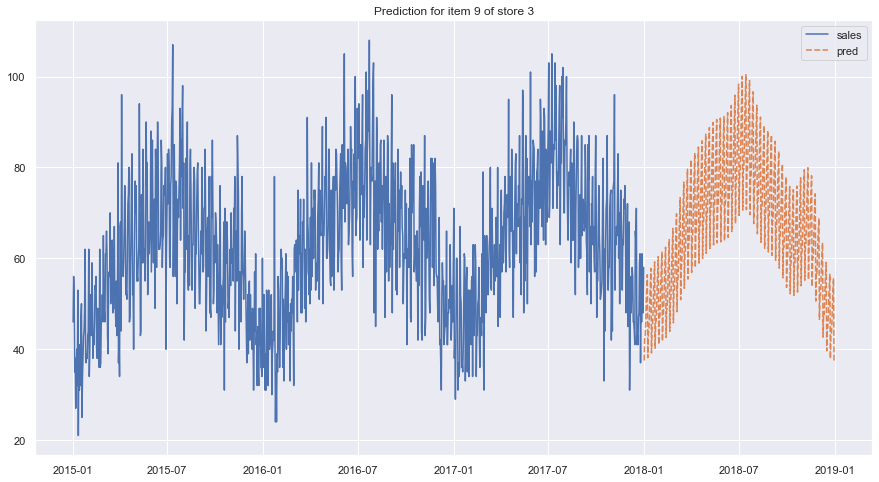

In [239]:
plot_prediction(tbats_pred, item=item, store=store, method='tbats')

In [293]:
score = [['sarima', 21.67227, 15.54698], ['sarima-fouier', 13.92061, 17.20388], \
         ['tbats', 13.39613, 14.78374], ['xgb', 17.00944, 18.53668], ['1st', 12.58015, 13.83614]]
score_df = pd.DataFrame(score, columns=['method', 'private', 'public'])
score_df = pd.melt(score_df, id_vars='method', value_vars=['private', 'public'], value_name='score')
score_df = score_df.sort_values(['score', 'method'])
score_df

,method,variable,score
4,1st,private,12.58015
2,tbats,private,13.39613
9,1st,public,13.83614
1,sarima-fouier,private,13.92061
7,tbats,public,14.78374
5,sarima,public,15.54698
3,xgb,private,17.00944
6,sarima-fouier,public,17.20388
8,xgb,public,18.53668
0,sarima,private,21.67227


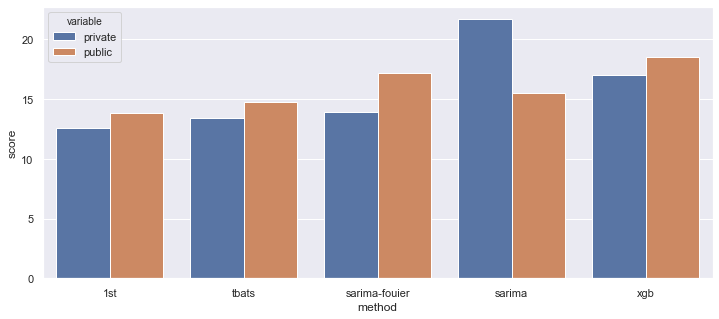

In [294]:
sns.set(rc={'figure.figsize':(12, 5)})
g = sns.barplot(data=score_df, x='method', y='score', hue='variable')
g.get_figure().savefig('plots/evaluation.jpg')
del g